In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from tensorflow_gan.python.losses.losses_impl import wasserstein_generator_loss, wasserstein_discriminator_loss

In [2]:
df = pd.read_csv("data/metadata.csv")

In [3]:
df

,card_file_name,id,link,name,rarity,setname,type
0,data/pictures/Base Set/Alakazam_(Base_Set_1),1/102,https://bulbapedia.bulbagarden.net/wiki/Alakaz...,Alakazam,Rare Holo,Base Set,Psychic
1,data/pictures/Base Set/Blastoise_(Base_Set_2),2/102,https://bulbapedia.bulbagarden.net/wiki/Blasto...,Blastoise,Rare Holo,Base Set,Water
2,data/pictures/Base Set/Chansey_(Base_Set_3),3/102,https://bulbapedia.bulbagarden.net/wiki/Chanse...,Chansey,Rare Holo,Base Set,Colorless
3,data/pictures/Base Set/Charizard_(Base_Set_4),4/102,https://bulbapedia.bulbagarden.net/wiki/Chariz...,Charizard,Rare Holo,Base Set,Fire
4,data/pictures/Base Set/Clefairy_(Base_Set_5),5/102,https://bulbapedia.bulbagarden.net/wiki/Clefai...,Clefairy,Rare Holo,Base Set,Colorless
...,...,...,...,...,...,...,...
9937,data/pictures/Pokémon Rumble/Lucario_(Pok%C3%A...,12/16,https://bulbapedia.bulbagarden.net/wiki/Lucari...,Lucario,Unknown rarity,Pokémon Rumble,Fighting
9938,data/pictures/Pokémon Rumble/Skuntank_(Pok%C3%...,13/16,https://bulbapedia.bulbagarden.net/wiki/Skunta...,Skuntank,Unknown rarity,Pokémon Rumble,Darkness
9939,data/pictures/Pokémon Rumble/Bastiodon_(Pok%C3...,14/16,https://bulbapedia.bulbagarden.net/wiki/Bastio...,Bastiodon,Unknown rarity,Pokémon Rumble,Metal
9940,data/pictures/Pokémon Rumble/Rattata_(Pok%C3%A...,15/16,https://bulbapedia.bulbagarden.net/wiki/Rattat...,Rattata,Unknown rarity,Pokémon Rumble,Colorless


# Drop a couple of bad records

In [4]:
df = df[~df["card_file_name"].isin([
    "data/pictures/Mysterious Treasures/Honchkrow_(Mysterious_Treasures_10)",
    "data/pictures/Unified Minds/Umbreon_%26_Darkrai-GX_(Unified_Minds_125)", # missing on website
    "data/pictures/Base Set/Charizard_(Base_Set_4)", # special version of normal website
    "data/pictures/Stormfront/Charizard_(Stormfront_103)", # special version of normal website
])]

filter to Pokemon types

In [5]:
# df.type.value_counts()
filter_to_pokemon_types = False
filter_to_simple_rarities = False

if filter_to_pokemon_types:
    df = df[df["type"].isin([
        "Water",
        "Grass",
        "Colorless",
        "Psychic",
        "Fighting",
        "Fire",
        "Lightning",
        "Darkness",
        "Metal",
        "Dragon",
        "Fairy",
    ])]

if filter_to_simple_rarities:
    df = df[df["rarity"].isin([
        "Common",
        "Uncommon",
        "Rare",
        "Rare Holo",
        "Rare Holo ex",
    ])]


# Parameters

In [25]:
n_epochs = 200
n_random_inputs_per_training = 800
n_real_per_training = 4000
batch_size = 100

n_generator_input = 100
n_generator_dense = 200

use_greyscale = False

columns_as_input = [
#     "rarity",
    "type",
#     "setname",
]

# Create dataset

In [7]:
# Function to load and preprocess each image
def parse_image_file(
    filename,
    label = None,
    crop=False,
    to_greyscale=False,
):
    img = tf.io.read_file(filename)
    img = tf.cast(tf.image.decode_jpeg(img, channels=3), tf.float32) / 255.0
    
#     if img.shape[0] < 50:
#         print(f"Error with image `{filename}`: shape found was small: {img.shape}")
    img = tf.image.resize_with_crop_or_pad(img, 260, 180)
    
    # Some images have an extra alpha channel. Remove that.
    img = img[:, :, :3]
    
    if crop:
        img = tf.image.crop_to_bounding_box(
            img, 
            offset_height = 35,
            offset_width = 20,
            target_height = 100,
            target_width = 140,
        )
        
    if to_greyscale:
        img = tf.image.rgb_to_grayscale(img)
        img = tf.expand_dims(img, -1)
    
    if label is None: return img
    else: return img, label

In [8]:
n_records = df.shape[0]

In [9]:
images = tf.constant(df["card_file_name"].values)
x = tf.stack([parse_image_file(img, crop=True, to_greyscale=use_greyscale) for img in images], axis=0)
gc.collect()

16

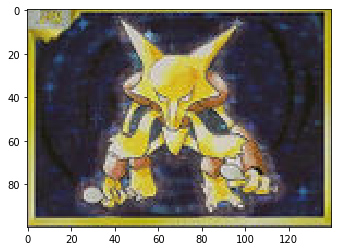

In [10]:
plt.imshow(tf.squeeze(x[0]), cmap='gray')

### Make the class dataset

In [26]:
def label_converter(label):
    return tf.math.argmax(label, axis=-1)

def make_conversion_function(classes):
    return lambda idx: convert_column(idx, classes)

def convert_column(idx, classes):
    return tf.gather(classes, idx)
    
def target_columns_to_tf(column_names):
    y = {}
    size_per_class = []
    conversion_functions = {}
    
    for colname in column_names:
        col = df[colname]
        classnames, indices = np.unique(col.values, return_inverse=True)
        classnames = np.append(classnames, "Fake")
        n_classes = len(classnames)
        size_per_class.append(n_classes)
        
        conversion_functions[colname] = make_conversion_function(classnames)
        y[colname] = keras.utils.to_categorical(indices, n_classes)

    return (
        y,
        size_per_class,
        conversion_functions,
    )

In [27]:
y, size_per_class, conversion_functions = target_columns_to_tf(columns_as_input)

def convert_target_matrix_to_label(pred, colname):
    current_start_index = 0
    pred = pred[colname]
    
    label_indices = label_converter(pred)
    return conversion_functions[colname](label_indices)


In [28]:
convert_target_matrix_to_label(y, columns_as_input[0])

<tf.Tensor: shape=(9938,), dtype=string, numpy=
array([b'Psychic', b'Water', b'Colorless', ..., b'Metal', b'Colorless',
       b'Colorless'], dtype=object)>

# Split dataset

In [29]:
all_data = tf.data.Dataset.from_tensor_slices(
    (x, y)
).shuffle(10000)

In [30]:
train_frac = .7
batch_size = 50

train = all_data.take(int(train_frac * n_records)).batch(batch_size)
remaining_data = all_data.skip(int(train_frac * n_records))

validate = remaining_data.take(int(.5 * (1 - train_frac) * n_records)).batch(batch_size)
test = remaining_data.skip(int(.5 * (1 - train_frac) * n_records)).batch(batch_size)

# Model

In [37]:
inputs = keras.layers.Input(shape=x[0].shape)
x_1 = keras.layers.Conv2D(filters=20, kernel_size=5, strides=2)(inputs)
x_1 = keras.layers.MaxPool2D()(x_1)
x_1 = keras.layers.Conv2D(filters=20, kernel_size=5, strides=2)(x_1)
x_1 = keras.layers.MaxPool2D()(x_1)
x_1 = keras.layers.Flatten()(x_1)
x_1 = keras.layers.Dense(units=50)(x_1)
x_1 = keras.layers.LeakyReLU()(x_1)
x_1 = keras.layers.Dense(units=50)(x_1)
x_1 = keras.layers.LeakyReLU()(x_1)
    
outputs = {
    colname: keras.layers.Dense(units=size, activation="softmax", name=colname)(x_1) 
    for colname, size in zip(columns_as_input, size_per_class)
}

model = keras.Model(inputs, outputs, name="multi-classifier")

In [38]:
model.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.categorical_accuracy]
)
model.summary()

Model: "multi-classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100, 140, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 68, 20)        1520      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 34, 20)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 15, 20)        10020     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 7, 20)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 700)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)           

# Training

In [39]:
gc.collect()
try:
    model.fit(train, validation_data=validate, epochs=22, shuffle=True)
finally:
    gc.collect()

Train for 140 steps, validate for 30 steps
Epoch 1/22
140/140 [==============================] - 10s 74ms/step - loss: 2.4886 - categorical_accuracy: 0.1922 - val_loss: 2.4977 - val_categorical_accuracy: 0.1651
Epoch 2/22
140/140 [==============================] - 10s 69ms/step - loss: 2.2926 - categorical_accuracy: 0.2481 - val_loss: 2.5669 - val_categorical_accuracy: 0.1584
Epoch 3/22
140/140 [==============================] - 10s 70ms/step - loss: 2.0945 - categorical_accuracy: 0.3035 - val_loss: 2.4031 - val_categorical_accuracy: 0.2396
Epoch 4/22
140/140 [==============================] - 10s 69ms/step - loss: 1.9753 - categorical_accuracy: 0.3427 - val_loss: 2.1180 - val_categorical_accuracy: 0.2564
Epoch 5/22
140/140 [==============================] - 10s 69ms/step - loss: 1.8939 - categorical_accuracy: 0.3689 - val_loss: 1.8893 - val_categorical_accuracy: 0.3604
Epoch 6/22
140/140 [==============================] - 10s 70ms/step - loss: 1.7816 - categorical_accuracy: 0.4061 - v

# Test a couple of records

In [45]:
def plot_and_predict(img):
    assert img.shape[0] == 1, "Please only provide a single image at a time"
    
    prediction = model.predict(img)
    labels = {k: convert_target_matrix_to_label(prediction, k) for k in prediction}
    
    plt.imshow(img[0])
    plt.title(labels)
    plt.title(class_name)
    

In [46]:
for vis_x, _ in train.take(1):
    for i in range(vis_x.shape[0]):
        plot_and_predict(vis_x[i:i+1])
        plt.show()
gc.collect()

IndexError: arrays used as indices must be of integer (or boolean) type